In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define dataset paths
dataset_dir = "dataset"
train_dir = "dataset_split/train"
validation_dir = "dataset_split/validation"

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Define classes
classes = ['glioma', 'healthy', 'meningioma', 'pituitary']

# Split data
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)
    
    # Split into train and validation
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create subdirectories for train and validation
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    
    # Move images to train/validation folders
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(validation_dir, class_name, img))


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'  # Multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 5617 images belonging to 4 classes.
Found 1406 images belonging to 4 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the CNN model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


C:\Users\ritaj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,217,156 (50.42 MB)

 Trainable params: 13,217,156 (50.42 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Save the trained model
model.save('mriclassifier_model.h5')


C:\Users\ritaj\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 116s 647ms/step - accuracy: 0.4135 - loss: 1.2813 - val_accuracy: 0.5484 - val_loss: 1.1833
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 106s 604ms/step - accuracy: 0.6505 - loss: 0.8457 - val_accuracy: 0.6671 - val_loss: 0.8154
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 569ms/step - accuracy: 0.7059 - loss: 0.7179 - val_accuracy: 0.3947 - val_loss: 2.1140
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 99s 560ms/step - accuracy: 0.7218 - loss: 0.6813 - val_accuracy: 0.4872 - val_loss: 1.4801
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 97s 552ms/step - accuracy: 0.7585 - loss: 0.6086 - val_accuracy: 0.6401 - val_loss: 0.9928
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 97s 550ms/step - accuracy: 0.7542 - loss: 0.5951 - val_accuracy: 0.5605 - val_loss: 1.2895
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 98s 553ms/step - accuracy: 0.7810 - loss: 0.5533 - val_accuracy: 0.7930 - val_loss: 0.5643
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 98s 556ms/step - accuracy: 0.7862 - loss

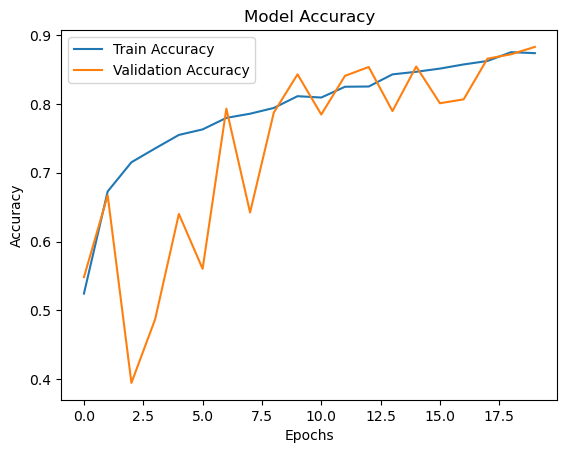

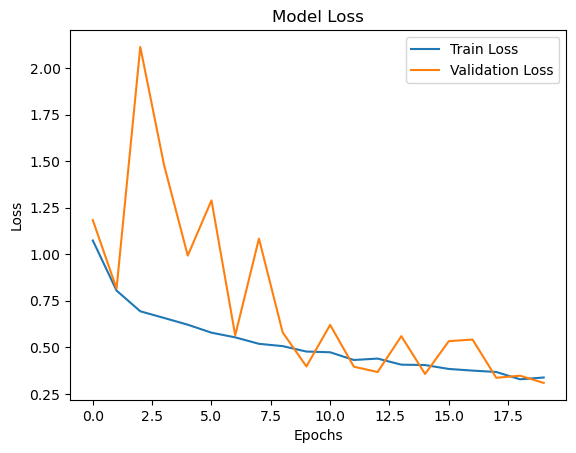

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess test image
test_image_path = "path_to_test_image.jpg"
image = load_img(test_image_path, target_size=(128, 128))
image_array = img_to_array(image) / 255.0  # Normalize
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(image_array)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
predicted_class = class_names[np.argmax(prediction)]
print(f"Predicted Class: {predicted_class}")


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_test_image.jpg'